In [1]:
import os 
import shutil 
import matplotlib.pyplot as plt 
import torchvision
import torch
import numpy as np
import torch.nn as nn
import tensorflow as tf
import torch.optim as optim
import glob 

from torchvision import datasets, transforms, models
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torch.utils.data import DataLoader
from skimage import io
from tensorflow.keras import layers, models
from tensorflow.keras.layers import Flatten, ReLU
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.callbacks import EarlyStopping
from torchsummary import summary

In [2]:
root_path = r'E:\MATKUL\SKRIPSI\PROGRAM\model\dataset'
source_path = os.path.join(root_path,'dataset mentah') #tempat dataset disimpan
destination_path = os.path.join(root_path, 'dataset resnet18')
class_remp = ['jahe', 'kencur', 'ketumbar', 'kunyit', 'lengkuas', 'merica']

In [3]:
#melihat banyak data gambar dlm folder
folders = {}

for folder in os.listdir(source_path):
    folders[folder] = len(os.listdir(os.path.join(source_path,  folder)))

folders

{'jahe': 300,
 'kencur': 300,
 'ketumbar': 300,
 'kunyit': 300,
 'lengkuas': 300,
 'merica': 300}

In [4]:
if os.path.isdir(os.path.join(destination_path, 'training')):
    print(f"path {os.path.join(destination_path, 'training')} sudah ada")
else:
    os.makedirs(os.path.join(destination_path, 'training'))
    for folder in folders.keys():
        os.makedirs(os.path.join(destination_path, f'training/{folder}'))

if os.path.isdir(os.path.join(destination_path, 'testing')):
    print(f"path {os.path.join(destination_path, 'testing')} sudah ada")
else:
    os.makedirs(os.path.join(destination_path, 'testing'))
    for folder in folders.keys():
        os.makedirs(os.path.join(destination_path, f'testing/{folder}'))

if os.path.isdir(os.path.join(destination_path, 'validasi')):
    print(f"path {os.path.join(destination_path, 'validasi')} sudah ada")
else:
    os.makedirs(os.path.join(destination_path, 'validasi'))
    for folder in folders.keys():
        os.makedirs(os.path.join(destination_path, f'validasi/{folder}'))

In [5]:
remp_path = os.path.join(source_path,class_remp[2],'*')
remp_path = glob.glob(remp_path)

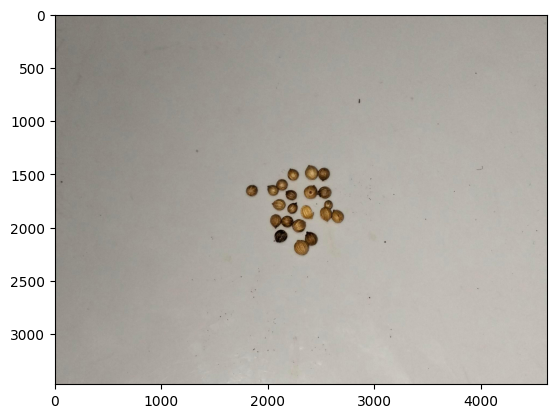

In [6]:
#Menampilkan gambar dari dataset
image = io.imread(remp_path[2])  

#memplot gambar original
i, (im1) = plt.subplots(1)
i.set_figwidth(15)
im1.imshow(image)

In [7]:
files_name = {
    'jahe': [],    
    'kencur': [],
    'ketumbar': [],    
    'kunyit': [],
    'lengkuas': [],
    'merica': [],    
}

files_train = {
    'jahe': [],    
    'kencur': [],
    'ketumbar': [],    
    'kunyit': [],
    'lengkuas': [],
    'merica': [],    
}

files_test = {
    'jahe': [],    
    'kencur': [],
    'ketumbar': [],    
    'kunyit': [],
    'lengkuas': [],
    'merica': [],    
}

In [8]:
for type in files_name.keys():
    for file in os.listdir(os.path.join(source_path, type)):
        if os.path.getsize(os.path.join(source_path, f'{type}/{file}')):
            files_name[type].append(file)
        else:
            print(f'{file} dilewatkan')

In [9]:
#test melihat panjang sebuah folder 
len(files_name['kencur'])

300

In [10]:
split_data = {
    'jahe': 0,    
    'kencur': 0,
    'ketumbar': 0,    
    'kunyit': 0,
    'lengkuas': 0,
    'merica': 0,    
}

for key in split_data.keys():
    split_data[key] = int(len(files_name[key])*.8)

for key in files_train.keys():
    files_train[key].append(files_name[key][:split_data[key]])
    files_test[key].append(files_name[key][split_data[key]:])

In [11]:
len(files_train['kencur'][0])

240

In [12]:
len(files_test['kencur'][0])

60

In [13]:
source_path

'E:\\MATKUL\\SKRIPSI\\PROGRAM\\model\\dataset\\dataset mentah'

In [14]:
destination_path

'E:\\MATKUL\\SKRIPSI\\PROGRAM\\model\\dataset\\dataset resnet18'

In [15]:
for type in files_name.keys():
    for file in files_train[type][0]:
        shutil.copyfile(
            os.path.join(source_path, f'{type}/{file}'),
            os.path.join(destination_path, f'training/{type}/{file}')
        )
    for file in files_test[type][0]:
        shutil.copyfile(
            os.path.join(source_path, f'{type}/{file}'),
            os.path.join(destination_path, f'testing/{type}/{file}')
        )
    for file in files_test[type][0]:
        shutil.copyfile(
            os.path.join(source_path, f'{type}/{file}'),
            os.path.join(destination_path, f'validasi/{type}/{file}')
        )

In [16]:
# Augmentasi data
dataset_transforms = transforms.Compose([
    transforms.RandomResizedCrop(size=(224, 224), scale=(0.8, 1.2)),    
    transforms.RandomHorizontalFlip(),    
    transforms.RandomRotation(40),    
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

In [17]:
train_dataset = torchvision.datasets.ImageFolder('E:\\MATKUL\\SKRIPSI\\PROGRAM\\model\\dataset\\dataset resnet18\\training', transform=dataset_transforms)
test_dataset = torchvision.datasets.ImageFolder('E:\\MATKUL\\SKRIPSI\\PROGRAM\\model\\dataset\\dataset resnet18\\testing', transform=dataset_transforms)
val_dataset = torchvision.datasets.ImageFolder('E:\\MATKUL\\SKRIPSI\\PROGRAM\\model\\dataset\\dataset resnet18\\validasi', transform=dataset_transforms)

In [18]:
train_load = torch.utils.data.DataLoader(train_dataset, batch_size=32, shuffle=True)
test_load = torch.utils.data.DataLoader(test_dataset, batch_size=32, shuffle=True)
val_load = torch.utils.data.DataLoader(val_dataset, batch_size=32, shuffle=True)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


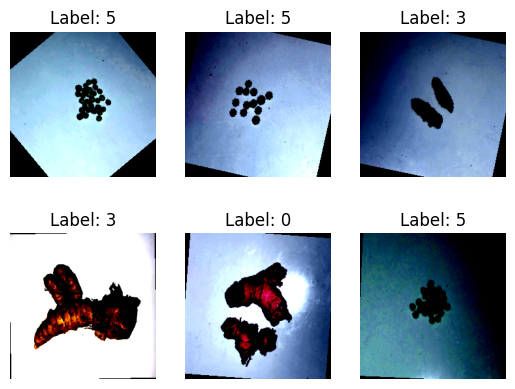

In [19]:
# Ambil batch gambar dari DataLoader
data_iter = iter(train_load)
images, labels = next(data_iter)

# Konversi tensor PyTorch ke array numpy
images = images.numpy()

# Ubah dimensi dari (batch_size, channels, height, width) menjadi (batch_size, height, width, channels)
images = np.transpose(images, (0, 2, 3, 1))

# Misalnya, tampilkan 6 gambar pertama dari batch
num_images_to_show = 6

for i in range(num_images_to_show):
    plt.subplot(2, 3, i + 1)  # Ubah angka 2, 3 sesuai dengan jumlah baris dan kolom yang Anda inginkan
    plt.imshow(images[i])
    plt.title(f"Label: {labels[i].item()}")
    plt.axis('off')

plt.show()

In [20]:
from torchvision import models

class CNNResNet(nn.Module):
    def __init__(self, num_classes):
        super(CNNResNet, self).__init__()
        # Bagian konvolusi (CNN)
        resnet18_model = models.resnet18(pretrained=True)
        self.resnet18_features = nn.Sequential(*list(resnet18_model.children())[:-1])  # Hapus lapisan fc terakhir

        # Lapisan-lapisan tambahan untuk klasifikasi
        self.fc1 = nn.Linear(512, 256)
        self.bn1 = nn.BatchNorm1d(256)  # Batch Normalization
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(256, num_classes)
        self.bn2 = nn.BatchNorm1d(num_classes)  # Batch Normalization

    def forward(self, x):
        x = self.resnet18_features(x)
        x = x.view(x.size(0), -1)
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        return x

# Inisialisasi model dan definisi fungsi loss serta optimizer
num_classes = len(class_remp)
model = CNNResNet(num_classes=num_classes)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# melihat model
summary(model, input_size=(3, 224, 224))

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

C:\Users\nanda\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\nanda\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]           9,408
       BatchNorm2d-2         [-1, 64, 112, 112]             128
              ReLU-3         [-1, 64, 112, 112]               0
         MaxPool2d-4           [-1, 64, 56, 56]               0
            Conv2d-5           [-1, 64, 56, 56]          36,864
       BatchNorm2d-6           [-1, 64, 56, 56]             128
              ReLU-7           [-1, 64, 56, 56]               0
            Conv2d-8           [-1, 64, 56, 56]          36,864
       BatchNorm2d-9           [-1, 64, 56, 56]             128
             ReLU-10           [-1, 64, 56, 56]               0
       BasicBlock-11           [-1, 64, 56, 56]               0
           Conv2d-12           [-1, 64, 56, 56]          36,864
      BatchNorm2d-13           [-1, 64, 56, 56]             128
             ReLU-14           [-1, 64,

CNNResNet(
  (resnet18_features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running

In [21]:
# Fungsi untuk pelatihan
def train(model, train_load, criterion, optimizer, device):
    model.train()
    running_loss = 0.0
    correct_predictions = 0
    total_samples = 0

    for inputs, labels in train_load:
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

        _, predicted = torch.max(outputs, 1)
        correct_predictions += (predicted == labels).sum().item()
        total_samples += labels.size(0)

    accuracy = correct_predictions / total_samples
    return running_loss / len(train_load), accuracy

# Fungsi untuk validasi
def validate(model, val_load, criterion, device):
    model.eval()
    running_loss = 0.0
    correct_predictions = 0
    total_samples = 0

    with torch.no_grad():
        for inputs, labels in val_load:
            inputs, labels = inputs.to(device), labels.to(device)

            outputs = model(inputs)
            loss = criterion(outputs, labels)

            running_loss += loss.item()

            _, predicted = torch.max(outputs, 1)
            correct_predictions += (predicted == labels).sum().item()
            total_samples += labels.size(0)

    accuracy = correct_predictions / total_samples
    return running_loss / len(val_load), accuracy

# Pelatihan model dengan 10 epochs
num_epochs = 10
best_val_accuracy = 0.0
consecutive_epochs = 0
patience = 5  # Jumlah epoch berturut-turut tanpa peningkatan pada data validasi sebelum early stopping

# Inisialisasi list untuk menyimpan data
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

# Definisi LR scheduler
scheduler = ReduceLROnPlateau(optimizer, mode='max', patience=2, factor=0.1, verbose=True)

for epoch in range(num_epochs):
    train_loss, train_accuracy = train(model, train_load, criterion, optimizer, device)
    val_loss, val_accuracy = validate(model, val_load, criterion, device)

    print(f"Epoch {epoch + 1}/{num_epochs} - Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.4f} - Val Loss: {val_loss:.4f}, Val Accuracy: {val_accuracy:.4f}")

    # Menyimpan data
    train_losses.append(train_loss)
    val_losses.append(val_loss)
    train_accuracies.append(train_accuracy)
    val_accuracies.append(val_accuracy)

    # Early stopping
    if val_accuracy > best_val_accuracy:
        best_val_accuracy = val_accuracy
        # Simpan model
        torch.save(model.state_dict(), './finished model/resnet18.pth')
        consecutive_epochs = 0
    else:
        consecutive_epochs += 1

    if consecutive_epochs >= patience:
        print("Early stopping. Model tidak memperoleh peningkatan pada data validasi.")
        break

    # Scheduler untuk mengatur learning rate berdasarkan performa data validasi
    scheduler.step(val_accuracy)

Epoch 1/10 - Train Loss: 0.5738, Train Accuracy: 0.7903 - Val Loss: 2.4988, Val Accuracy: 0.5694
Epoch 2/10 - Train Loss: 0.3660, Train Accuracy: 0.8819 - Val Loss: 1.0739, Val Accuracy: 0.5500
Epoch 3/10 - Train Loss: 0.2212, Train Accuracy: 0.9257 - Val Loss: 1.2306, Val Accuracy: 0.7278
Epoch 4/10 - Train Loss: 0.1989, Train Accuracy: 0.9368 - Val Loss: 1.7529, Val Accuracy: 0.6056
Epoch 5/10 - Train Loss: 0.1721, Train Accuracy: 0.9451 - Val Loss: 0.6596, Val Accuracy: 0.8083
Epoch 6/10 - Train Loss: 0.1586, Train Accuracy: 0.9521 - Val Loss: 0.8620, Val Accuracy: 0.7000
Epoch 7/10 - Train Loss: 0.1322, Train Accuracy: 0.9521 - Val Loss: 0.8543, Val Accuracy: 0.7806
Epoch 8/10 - Train Loss: 0.2327, Train Accuracy: 0.9368 - Val Loss: 2.0418, Val Accuracy: 0.5472
Epoch 00008: reducing learning rate of group 0 to 1.0000e-04.
Epoch 9/10 - Train Loss: 0.1378, Train Accuracy: 0.9556 - Val Loss: 0.5505, Val Accuracy: 0.8167
Epoch 10/10 - Train Loss: 0.0736, Train Accuracy: 0.9778 - Val Lo

In [22]:
# Evaluasi model pada data uji
def evaluate(model, test_load, criterion, device):
    model.eval()
    running_loss = 0.0
    correct_predictions = 0
    total_samples = 0

    with torch.no_grad():
        for inputs, labels in test_load:
            inputs, labels = inputs.to(device), labels.to(device)

            outputs = model(inputs)
            loss = criterion(outputs, labels)

            running_loss += loss.item()

            _, predicted = torch.max(outputs, 1)
            correct_predictions += (predicted == labels).sum().item()
            total_samples += labels.size(0)

    accuracy = correct_predictions / total_samples
    return running_loss / len(test_load), accuracy

# Gantilah 'test_load' dengan loader data uji yang sesuai
test_loss, test_accuracy = evaluate(model, test_load, criterion, device)

print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy * 100:.2f}%")


Test Loss: 0.3722, Test Accuracy: 88.61%


In [ ]:
# Evaluasi model pada data validasi setelah pelatihan selesai
final_val_loss, final_val_accuracy = validate(model, val_load, criterion, device)
print(f"Final Validation Loss: {final_val_loss:.4f}, Final Validation Accuracy: {final_val_accuracy * 100:.2f}%")

In [ ]:
# Membuat plot
plt.figure(figsize=(12, 4))

# Plot Loss
plt.subplot(1, 2, 1)
plt.plot(range(1, len(train_losses) + 1), train_losses, label='Train Loss')
plt.plot(range(1, len(val_losses) + 1), val_losses, label='Validation Loss')
plt.title('Training and Validation Loss Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Plot Accuracy
plt.subplot(1, 2, 2)
plt.plot(range(1, len(train_accuracies) + 1), train_accuracies, label='Train Accuracy')
plt.plot(range(1, len(val_accuracies) + 1), val_accuracies, label='Validation Accuracy')
plt.title('Training and Validation Accuracy Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Menyimpan plot ke file gambar
plt.savefig('training_metrics_plot.png')

# Menampilkan plot
plt.show()

In [ ]:
torch.save(model.state_dict(), 'resnet18.pth')